In [1]:
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import numpy as np

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/1512/PA/mhist_dataset.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
IMAGE_SIZE = (224, 224, 3)
NUM_CLASSES = 2
learning_rate_teacher_init = 1e-4
learning_rate_student_init = 1e-3
NUM_EPOCHS_init = 10
NUM_EPOCHS_ft = 25

# Custom dataset and dataloader

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import math
from PIL import Image
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
np.random.seed(42)
csv_path = './annotations.csv'
image_path = './images/images'
# model(torch.tensor(np.ones((1, 224,224,3))), training=True)
class Custom_Dataset(Dataset):
    def __init__(self, image_path, csv_path, transformer, split):
        self.image_path = image_path
        self.csv_path = csv_path
        annotations = pd.read_csv(csv_path)
        image_names = annotations ['Image Name']
        majority_vote_labels = annotations ['Majority Vote Label']
        self.train_image_names = np.array(image_names[annotations['Partition']=='train'])
        self.train_mv_labels = np.array(majority_vote_labels[annotations['Partition']=='train'])      
        self.test_image_names = np.array(image_names[annotations['Partition']=='test'])
        self.test_mv_labels = np.array(majority_vote_labels[annotations['Partition']=='test'])       
        self.transformer = transformer
        self.split = split
        
    def __len__(self):
        if self.split == 'train':
            return len(self.train_mv_labels)
        else:
            return len(self.test_mv_labels)
    
    def __getitem__(self, idx):
        if self.split == 'train':        
            image_full_name = os.path.join(self.image_path, self.train_image_names[idx])
            x = Image.open(image_full_name)
            if self.transformer is not None:
                x = self.transformer(x)
                x = x.permute(1,2,0)
            
            label = self.train_mv_labels[idx]
            if label == 'HP':
                y = np.array([1, 0])
            else:
                y = np.array([0, 1])
                
        else:        
            image_full_name = os.path.join(self.image_path, self.test_image_names[idx])
            x = Image.open(image_full_name)
            if self.transformer is not None:
                x = self.transformer(x)
                x = x.permute(1,2,0)

            label = self.test_mv_labels[idx]
            if label == 'HP':
                y = np.array([1, 0])
            else:
                y = np.array([0, 1])
                
        return x, y
    
custom_transformer = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

custom_transformer_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
      
train_dataset = Custom_Dataset(image_path, csv_path, custom_transformer, 'train')
test_dataset = Custom_Dataset(image_path, csv_path, custom_transformer_test, 'test')
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset))
print(len(test_dataset))

2175
977


# Train and evaluation

In [5]:
def tf_reduceat(data, at_array, axis=-1):
    split_data = tf.split(data, at_array, axis=axis)
    return tf.stack([tf.reduce_sum(i, axis=axis) for i in split_data], axis=axis)
    
# def compute_num_correct(model, images, labels):
#     class_logits = model(images, training=False)
#     if class_logits.shape[1] != NUM_CLASSES:
#         class_logits = tf_reduceat(class_logits, [8, 8])
        
#     return tf.reduce_sum(
#       tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
#               tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def compute_auc(model, images, labels):
    class_logits = model(images, training=False)
    if class_logits.shape[1] != NUM_CLASSES:
        class_logits = tf_reduceat(class_logits, [8, 8])
    
    scores = tf.nn.sigmoid(class_logits)
    m1 = tf.keras.metrics.AUC()
    m1.reset_state()
    m1.update_state(labels, scores)
    return m1.result().numpy()

def train_and_evaluate(model, compute_loss_fn, learning_rate, train_loader, test_loader, num_total):
    print('Start initial epochs')
    # do initial training epochs
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(1, NUM_EPOCHS_init + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    #unfreezing all layers
    for layer in model.layers:
        layer.trainable = True
    print('\n')
    print('Start fine-tuning epochs')
    # do initial training epochs
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate/10)
    for epoch in range(1, NUM_EPOCHS_ft + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in train_loader:
            with tf.GradientTape() as tape:
                images = tf.convert_to_tensor(images.numpy())
                labels = tf.convert_to_tensor(labels.numpy())
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    AUC_set = []
    for images, labels in test_loader:
        images = tf.convert_to_tensor(images.numpy())
        labels = tf.convert_to_tensor(labels.numpy())
        AUC_set.append(compute_auc(model, images, labels))

    test_AUC = sum(AUC_set)/len(AUC_set)
    print('\n')
    print("Test AUC: " + '{:.2f}'.format(test_AUC))
    return test_AUC


# Train student model from scratch first

In [6]:
mobile_model_scratch = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
#freeze pre-trained mobilenet layers for initial epochs
for layer in mobile_model_scratch.layers:
    layer.trainable = False
    
#Design the last dense layer
x_student_scratch = Dense(2, activation=None)(mobile_model_scratch.output)
x_student_scratch.trainable = True

student_model_scratch = Model(inputs=mobile_model_scratch.input, outputs=x_student_scratch)

def compute_plain_cross_entropy_loss(images, labels):

    student_subclass_logits = student_model_scratch(images, training=True)
    cross_entropy_loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))

    return cross_entropy_loss


train_and_evaluate(student_model_scratch, compute_plain_cross_entropy_loss, learning_rate_student_init, train_loader, test_loader, len(test_dataset))

Start initial epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 

Start fine-tuning epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 

Test AUC: 0.83


0.826843173273148

# Load pre-trained ResNet50V2 model for teacher

In [7]:
resnet_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
#freeze pre-trained resnet layers for initial epochs
for layer in resnet_model.layers:
    layer.trainable = False
    
#Design the last dense layer
x_teacher = Dense(2,activation=None)(resnet_model.output)
x_teacher.trainable = True

teacher_model_kd = Model(inputs=resnet_model.input, outputs=x_teacher)

# mobile_model = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
# #freeze pre-trained mobilenet layers for initial epochs
# for layer in mobile_model.layers:
#     layer.trainable = False
    
# #Design the last dense layer
# x_student = Dense(2,activation=None)(mobile_model.output)
# x_student.trainable = True

# student_model_kd = Model(inputs=mobile_model.input, outputs=x_student)

102869336/102869336 [==============================] - 5s 0us/step


# Teacher loss function

In [8]:
def compute_teacher_loss(images, labels):

    subclass_logits = teacher_model_kd(images, training=True)

    cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, subclass_logits))

    return cross_entropy_loss_value

# Student loss function

In [9]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter

def distillation_loss(teacher_logits, student_logits, temperature = DISTILLATION_TEMPERATURE):

    soft_targets = tf.nn.softmax(teacher_logits/temperature, axis = 1)
    
    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):

    student_subclass_logits = student_model_kd(images, training=True)
    teacher_subclass_logits = teacher_model_kd(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))
    
    total_loss = cross_entropy_loss_value * ALPHA + (1 - ALPHA) * distillation_loss_value

    return total_loss

# Train teacher model

In [10]:
print('Start training teacher model')
test_acc_teacher = train_and_evaluate(teacher_model_kd, compute_teacher_loss, learning_rate_teacher_init, train_loader, test_loader, len(test_dataset))
print('Test accuracy for teacher model is {} %'.format(test_acc_teacher))
print('-------------------------------------')
# print('Start training student model')
# test_acc_student = train_and_evaluate(student_model_kd, compute_student_loss, learning_rate_student_init, train_loader, test_loader, len(test_dataset))
# print('Test accuracy for student model is {} %'.format(test_acc_student))

Start training teacher model
Start initial epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 

Start fine-tuning epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 

Test AUC: 0.86
Test accuracy for teacher model is 0.8641310968706685 %
-------------------------------------


# Train student models with different temperature values

In [11]:
temperature_set = [1,2,4,16,32,64]
test_auc_set = []
for temp in temperature_set:

    mobile_model = MobileNetV2(include_top=True, weights='imagenet', input_shape=IMAGE_SIZE)
    #freeze pre-trained mobilenet layers for initial epochs
    for layer in mobile_model.layers:
        layer.trainable = False
        
    #Design the last dense layer
    x_student = Dense(2,activation=None)(mobile_model.output)
    x_student.trainable = True

    student_model_kd = Model(inputs=mobile_model.input, outputs=x_student)

    DISTILLATION_TEMPERATURE = temp
    test_auc_i = train_and_evaluate(student_model_kd, compute_student_loss, learning_rate_student_init, train_loader, test_loader, len(test_dataset))
    test_auc_set.append(test_auc_i)

Start initial epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 

Start fine-tuning epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 

Test AUC: 0.73
Start initial epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 

Start fine-tuning epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 25: 

Test AUC: 0.71
Start initial epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 

Start fine-tuning epochs
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoc

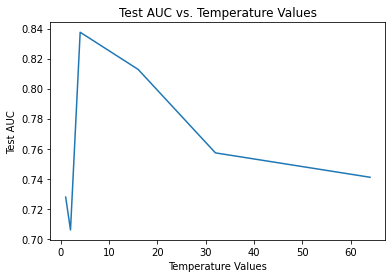

In [12]:
import matplotlib.pyplot as plt

plt.plot(temperature_set, test_auc_set)

plt.xlabel('Temperature Values')
plt.ylabel('Test AUC')    
plt.title('Test AUC vs. Temperature Values')
plt.show()

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [13]:
!pip install keras_flops
from keras_flops import get_flops
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('teacher model summary')
teacher_model_kd.summary()
print('fc model summary')
student_model_kd.summary()
flops = get_flops(teacher_model_kd, batch_size=1)
print('FLOPs for teacher model is {}'.format(flops))
flops = get_flops(student_model_kd, batch_size=1)
print('FLOPs for student model is {}'.format(flops))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
teacher model summary
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                     